In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, precision_recall_curve

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import mlflow
import mlflow.sklearn

import warnings
warnings.filterwarnings('ignore')

In [5]:
data = pd.read_csv(r"D:\Amnil Internship code\Credit_card Fraud Detection\Credit_card_transactions.csv\credit_card_transactions.csv")
data.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,merch_zipcode
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,28705.0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,NaN
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,83236.0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,NaN
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,22844.0


In [6]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 24 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long              

In [7]:
print(data.columns)

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud', 'merch_zipcode'],
      dtype='object')


In [8]:
print(data.isnull().sum())

Unnamed: 0                    0
trans_date_trans_time         0
cc_num                        0
merchant                      0
category                      0
amt                           0
first                         0
last                          0
gender                        0
street                        0
city                          0
state                         0
zip                           0
lat                           0
long                          0
city_pop                      0
job                           0
dob                           0
trans_num                     0
unix_time                     0
merch_lat                     0
merch_long                    0
is_fraud                      0
merch_zipcode            195973
dtype: int64


In [9]:
print(data['is_fraud'].value_counts())

is_fraud
0    1289169
1       7506
Name: count, dtype: int64


In [10]:
print(data['is_fraud'].value_counts(normalize=True) * 100)

is_fraud
0    99.421135
1     0.578865
Name: proportion, dtype: float64


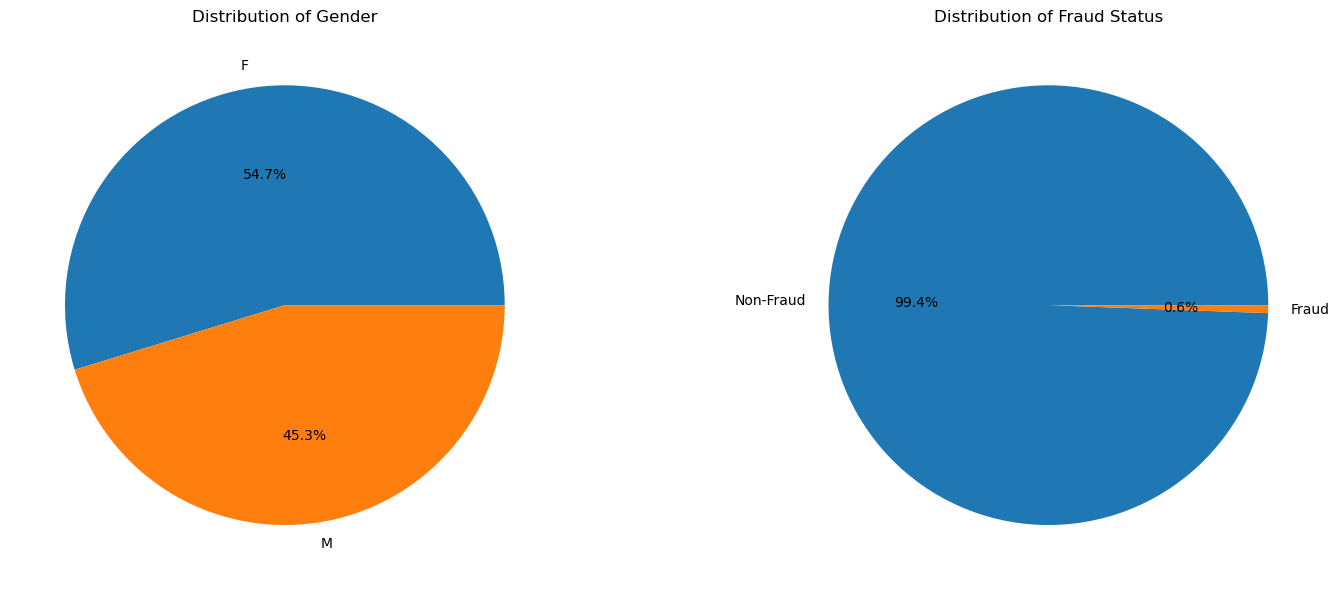

In [11]:
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Plot pie chart for gender
gender_counts = data['gender'].value_counts()
axs[0].pie(gender_counts.values, labels=gender_counts.index, autopct='%1.1f%%')
axs[0].set_title('Distribution of Gender')

# Plot pie chart for is_fraud
fraud_counts = data['is_fraud'].value_counts()
axs[1].pie(fraud_counts.values, labels=['Non-Fraud', 'Fraud'], autopct='%1.1f%%')
axs[1].set_title('Distribution of Fraud Status')

# Layout so plots do not overlap
plt.tight_layout()

plt.show()

The dataset is highly imbalanced with very few fraud cases compared to non-fraud cases(7506 frauds in 1289169 samples). This imbalance can lead to biased model performance, where the model may perform well on the majority class (non-fraud) but poorly on the minority class (fraud). To address this, techniques such as oversampling the minority class, undersampling the majority class, or using specialized algorithms designed for imbalanced datasets can be employed.

In [12]:
# Separate fraud (1) and non-fraud (0)
fraud = data[data['is_fraud'] == 1]
non_fraud = data[data['is_fraud'] == 0]

# Take all fraud cases
fraud_data = fraud  

# Randomly sample 100k from non-fraud
non_fraud_data = non_fraud.sample(n=100000, random_state=42)

# Combine them
data = pd.concat([fraud_data, non_fraud_data])

# Shuffle the dataset
data = data.sample(frac=1, random_state=42).reset_index(drop=True)


In [13]:
print(data.shape)

(107506, 24)


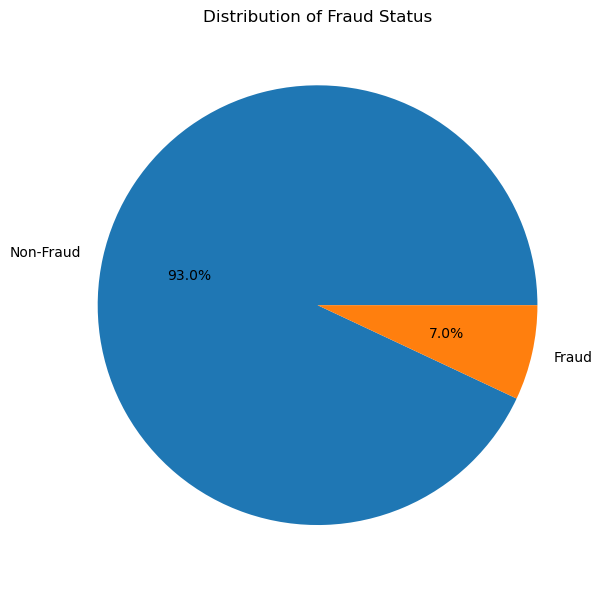

In [14]:
#create a piechart to show fraud and non fraud cases
# Create a figure with two subplots
fig, axs = plt.subplots(figsize=(16, 6))    
# Plot pie chart for is_fraud
fraud_counts = data['is_fraud'].value_counts()
axs.pie(fraud_counts.values, labels=['Non-Fraud', 'Fraud'], autopct='%1.1f%%')
axs.set_title('Distribution of Fraud Status')
# Layout so plots do not overlap
plt.tight_layout()
plt.show()

In [15]:
from datetime import datetime

# Transform trans_date_trans_time to extract time features
data['trans_date_trans_time'] = pd.to_datetime(data['trans_date_trans_time'])

# Extract time-based features
data['hour'] = data['trans_date_trans_time'].dt.hour
data['day_of_week'] = data['trans_date_trans_time'].dt.dayofweek  # 0=Monday, 6=Sunday
data['month'] = data['trans_date_trans_time'].dt.month

In [16]:
print(data['day_of_week'].value_counts())

day_of_week
0    20958
6    20476
5    16843
1    13261
4    12874
3    12186
2    10908
Name: count, dtype: int64


In [17]:
#Transform dob to age
data['dob'] = pd.to_datetime(data['dob'])
data['age'] = data['trans_date_trans_time'].dt.year - data['dob'].dt.year

In [18]:
# Haversine formula to calculate distance in kilometers between customer and merchant
R = 6371  # Earth radius in kilometers
lat1 = np.radians(data['lat'])
lon1 = np.radians(data['long'])
lat2 = np.radians(data['merch_lat'])
lon2 = np.radians(data['merch_long'])

dlat = lat2 - lat1
dlon = lon2 - lon1

a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
c = 2 * np.arcsin(np.sqrt(a))
data['dist_km'] = R * c


In [19]:
#Drop unnecessary columns
drop_cols = ['Unnamed: 0','cc_num','first','last','street','trans_num','unix_time','trans_date_trans_time','dob'
             ,'merch_zipcode']
data = data.drop(columns=drop_cols, axis=1)
data.head()

,merchant,category,amt,gender,city,state,zip,lat,long,city_pop,job,merch_lat,merch_long,is_fraud,hour,day_of_week,month,age,dist_km
0,"fraud_Stehr, Jewess and Schimmel",misc_net,110.33,M,Bridger,MT,59014,45.2857,-108.9082,1446,Chartered loss adjuster,45.694334,-109.066810,0,5,0,5,41,47.090093
1,fraud_Cormier LLC,shopping_net,84.46,M,Arcadia,OH,44804,41.1116,-83.5020,1202,Curator,41.863732,-83.054106,0,5,3,8,86,91.576857
2,fraud_Upton PLC,entertainment,81.11,M,Reno,NV,89512,39.5483,-119.7957,276896,Immunologist,39.604061,-120.531486,0,14,0,9,22,63.365631
3,fraud_Towne LLC,misc_pos,3.99,M,Espanola,NM,87533,35.9866,-106.0654,18408,Historic buildings inspector/conservation officer,36.546189,-105.428412,0,19,3,9,47,84.457344
4,fraud_Crona and Sons,kids_pets,22.24,M,Lohrville,IA,51453,42.2619,-94.5566,695,Administrator,41.690108,-93.584278,0,17,5,4,66,102.482612


These dropped columns are not necessary for the analysis and could potentially introduce noise or bias into the model. For example, 'cc_num' is sensitive information that should not be used in fraud detection models. Other columns like 'first', 'last', 'street', also do not contribute to the predictive power of the model and can be safely removed to streamline the dataset.insted of street we can use 'city','state','zip' for location based analysis.

In [20]:
print(data.columns)

Index(['merchant', 'category', 'amt', 'gender', 'city', 'state', 'zip', 'lat',
       'long', 'city_pop', 'job', 'merch_lat', 'merch_long', 'is_fraud',
       'hour', 'day_of_week', 'month', 'age', 'dist_km'],
      dtype='object')


In [21]:
print(data.shape)

(107506, 19)


In [22]:
# Check data types and identify categorical columns
print("Data types:")
print(data.dtypes)

print("\nCategorical columns (object type):")
categorical_cols = data.select_dtypes(include=['object']).columns.tolist()
if 'is_fraud' in categorical_cols:
    categorical_cols.remove('is_fraud')  # Remove target variable
print(categorical_cols)

print("\nUnique values in each categorical column:")
for col in categorical_cols:
    print(f"{col}: {data[col].nunique()} unique values")

Data types:
merchant        object
category        object
amt            float64
gender          object
city            object
state           object
zip              int64
lat            float64
long           float64
city_pop         int64
job             object
merch_lat      float64
merch_long     float64
is_fraud         int64
hour             int32
day_of_week      int32
month            int32
age              int32
dist_km        float64
dtype: object

Categorical columns (object type):
['merchant', 'category', 'gender', 'city', 'state', 'job']

Unique values in each categorical column:
merchant: 693 unique values
category: 14 unique values
gender: 2 unique values
city: 894 unique values
state: 51 unique values
job: 494 unique values


In [23]:
# Categorize columns by number of unique values
low_cardinality = []    # <= 10 unique values (good for one-hot encoding)
medium_cardinality = [] # 11-50 unique values (can use one-hot or target encoding)
high_cardinality = []   # > 50 unique values (use target encoding or grouping)

categorical_cols = ['merchant', 'category', 'gender', 'city', 'state', 'job']

for col in categorical_cols:
    unique_count = data[col].nunique()
    if unique_count <= 10:
        low_cardinality.append(col)
    elif unique_count <= 50:
        medium_cardinality.append(col)
    else:
        high_cardinality.append(col)

print("Categorization for encoding strategy:")
print(f"Low cardinality (≤10): {low_cardinality}")
print(f"Medium cardinality (11-50): {medium_cardinality}")  
print(f"High cardinality (>50): {high_cardinality}")

Categorization for encoding strategy:
Low cardinality (≤10): ['gender']
Medium cardinality (11-50): ['category']
High cardinality (>50): ['merchant', 'city', 'state', 'job']


In [24]:
print(data['gender'].value_counts()) 

gender
F    58332
M    49174
Name: count, dtype: int64


In [25]:
#One Hot Encoding for low cardinality categorical variables(Gender)
data = pd.get_dummies(data, columns=low_cardinality)
print(data.head())


                           merchant       category     amt       city state  \
0  fraud_Stehr, Jewess and Schimmel       misc_net  110.33    Bridger    MT   
1                 fraud_Cormier LLC   shopping_net   84.46    Arcadia    OH   
2                   fraud_Upton PLC  entertainment   81.11       Reno    NV   
3                   fraud_Towne LLC       misc_pos    3.99   Espanola    NM   
4              fraud_Crona and Sons      kids_pets   22.24  Lohrville    IA   

     zip      lat      long  city_pop  \
0  59014  45.2857 -108.9082      1446   
1  44804  41.1116  -83.5020      1202   
2  89512  39.5483 -119.7957    276896   
3  87533  35.9866 -106.0654     18408   
4  51453  42.2619  -94.5566       695   

                                                 job  merch_lat  merch_long  \
0                            Chartered loss adjuster  45.694334 -109.066810   
1                                            Curator  41.863732  -83.054106   
2                                       I

In [26]:
#Label Encoding for medium cardinality categorical variables (Category)
from sklearn.preprocessing import LabelEncoder

for col in medium_cardinality:
    le = LabelEncoder()  # New encoder for each column
    data[col] = le.fit_transform(data[col])

print(data.head())

                           merchant  category     amt       city state    zip  \
0  fraud_Stehr, Jewess and Schimmel         8  110.33    Bridger    MT  59014   
1                 fraud_Cormier LLC        11   84.46    Arcadia    OH  44804   
2                   fraud_Upton PLC         0   81.11       Reno    NV  89512   
3                   fraud_Towne LLC         9    3.99   Espanola    NM  87533   
4              fraud_Crona and Sons         7   22.24  Lohrville    IA  51453   

       lat      long  city_pop  \
0  45.2857 -108.9082      1446   
1  41.1116  -83.5020      1202   
2  39.5483 -119.7957    276896   
3  35.9866 -106.0654     18408   
4  42.2619  -94.5566       695   

                                                 job  merch_lat  merch_long  \
0                            Chartered loss adjuster  45.694334 -109.066810   
1                                            Curator  41.863732  -83.054106   
2                                       Immunologist  39.604061 -120.53

In [27]:
#Label Encoding for high cardinality categorical variables ('merchant', 'city', 'state', 'job')
from sklearn.preprocessing import LabelEncoder
for col in high_cardinality:
    le = LabelEncoder()  # New encoder for each column
    data[col] = le.fit_transform(data[col])
print(data.head())

   merchant  category     amt  city  state    zip      lat      long  \
0       597         8  110.33    95     26  59014  45.2857 -108.9082   
1       105        11   84.46    26     35  44804  41.1116  -83.5020   
2       644         0   81.11   684     33  89512  39.5483 -119.7957   
3       629         9    3.99   252     32  87533  35.9866 -106.0654   
4       112         7   22.24   451     12  51453  42.2619  -94.5566   

   city_pop  job  merch_lat  merch_long  is_fraud  hour  day_of_week  month  \
0      1446   70  45.694334 -109.066810         0     5            0      5   
1      1202  114  41.863732  -83.054106         0     5            3      8   
2    276896  242  39.604061 -120.531486         0    14            0      9   
3     18408  226  36.546189 -105.428412         0    19            3      9   
4       695    6  41.690108  -93.584278         0    17            5      4   

   age     dist_km  gender_F  gender_M  
0   41   47.090093     False      True  
1   86   9

In [28]:
#Split the data into features and target variable
X = data.drop(columns=['is_fraud'])
y = data['is_fraud']

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [29]:
print(data.columns)

Index(['merchant', 'category', 'amt', 'city', 'state', 'zip', 'lat', 'long',
       'city_pop', 'job', 'merch_lat', 'merch_long', 'is_fraud', 'hour',
       'day_of_week', 'month', 'age', 'dist_km', 'gender_F', 'gender_M'],
      dtype='object')


In [30]:
#Scaling numerial features
numerical_cols = ['amt','zip','lat', 'long','city_pop', 'merch_lat', 'merch_long', 'age', 'dist_km', 'hour', 'day_of_week', 'month']

from sklearn.compose import ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols)
    ], remainder='passthrough'
)


In [31]:
rf_pipe= ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('clf', RandomForestClassifier(random_state=42,n_jobs=1))
])

GridSearchCv for hyperparameter tuning

In [32]:
#Random Forest Classifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

rf_param_grid = {
    'clf__n_estimators': [50,100,200],
    'clf__max_depth': [None, 10, 20],
    'clf__min_samples_split': [2, 5]
}
cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf_search = GridSearchCV(rf_pipe, rf_param_grid,cv=cv, scoring='f1',
                         n_jobs=-1,verbose=2, refit=True)

rf_search.fit(X_train, y_train)
print("RF best params:", rf_search.best_params_)


Fitting 5 folds for each of 18 candidates, totalling 90 fits
RF best params: {'clf__max_depth': None, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}


In [33]:
# #XGBoost Classifier

# xgb_pipe = ImbPipeline([
#     ('smote', SMOTE(random_state=42)),
#     ('clf', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
# ])

# xgb_param_grid = {
#     'clf__n_estimators': [100,200, 300],
#     'clf__max_depth': [3, 6],
#     'clf__learning_rate': [0.1, 0.01]
# }

# xgb_search = GridSearchCV(xgb_pipe, xgb_param_grid, cv=5, scoring='f1',
#                           n_jobs=-1, verbose=2)
# xgb_search.fit(X_train, y_train)
# print("XGB best params:", xgb_search.best_params_)

In [34]:
# #LightGBM Classifier

# lgbm_pipe = ImbPipeline([
#     ('preprocessor', preprocessor),
#     ('smote', SMOTE(random_state=42)),
#     ('clf', LGBMClassifier(random_state=42))
# ])

# lgbm_param_grid = {
#     'clf__n_estimators': [100, 300],
#     'clf__num_leaves': [31, 63],
#     'clf__learning_rate': [0.1, 0.01]
# }

# lgbm_search = GridSearchCV(lgbm_pipe, lgbm_param_grid, cv=5, scoring='f1',
#                            n_jobs=-1, verbose=2)
# lgbm_search.fit(X_train, y_train)
# print("LGBM best params:", lgbm_search.best_params_)

In [35]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, classification_report

In [36]:
best_rf_model = rf_search.best_estimator_

#Evaluate on test set
y_pred = best_rf_model.predict(X_test)
y_prob = best_rf_model.predict_proba(X_test)[:, 1] if hasattr(best_rf_model,"predict_proba")else None


In [37]:
 # Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
if y_prob is not None:
    roc_auc = roc_auc_score(y_test, y_prob)
else:
    roc_auc = None

print(f"Accuracy={accuracy:.4f}, F1={f1:.4f}, Precision={precision:.4f}, Recall={recall:.4f}")
if roc_auc is not None:
    print(f"ROC AUC={roc_auc:.4f}")

Accuracy=0.9827, F1=0.8739, Precision=0.8924, Recall=0.8561
ROC AUC=0.9897



Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     20001
           1       0.89      0.86      0.87      1501

    accuracy                           0.98     21502
   macro avg       0.94      0.92      0.93     21502
weighted avg       0.98      0.98      0.98     21502



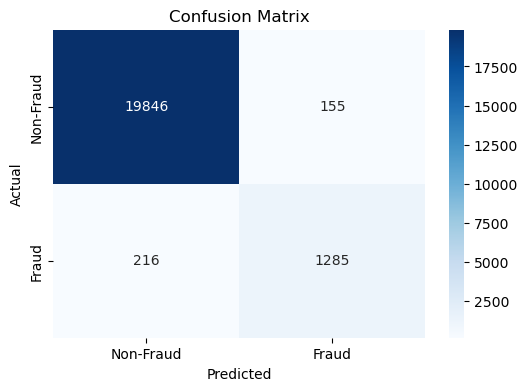

In [38]:
#print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
#EDA and Feature Engineering

#Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [42]:
#Tracking experiments with MLflow
import joblib
import mlflow
import mlflow.sklearn

best_rf = rf_search.best_estimator_

#Log wiwth MLflow
mlflow.set_experiment("Random_Forest_Credit_Card_Fraud_Detections1")
mlflow.set_tracking_uri("http://127.0.0.1:5000")


with mlflow.start_run():
    
    # log best params
    mlflow.log_params(rf_search.best_params_)
   
    # log metrics
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    if roc_auc is not None:
        mlflow.log_metric("roc_auc", roc_auc)       


🏃 View run persistent-gnat-382 at: http://127.0.0.1:5000/#/experiments/586583135819109561/runs/47c2baed2daf49a589d8c73cc8ccd17d
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/586583135819109561


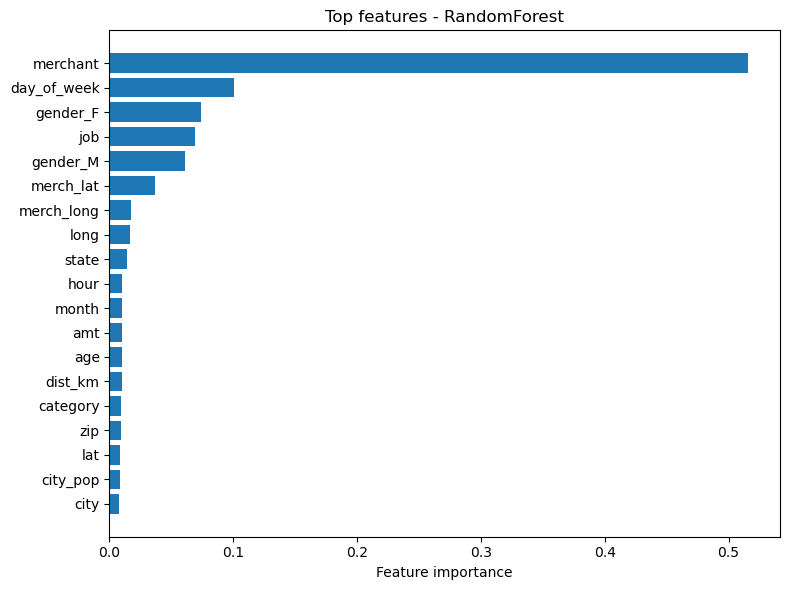

<Figure size 640x480 with 0 Axes>

In [43]:
#Feature importance 
# visualize feature importance for RandomForest

# get the classifier inside the pipeline
clf = rf_search.best_estimator_.named_steps['clf']

# if using pandas DataFrame for X:
feature_names = X_train.columns.tolist()

importances = clf.feature_importances_
# sort
idx = np.argsort(importances)[::-1]
top_n = 20  # change as needed

plt.figure(figsize=(8,6))
plt.barh([feature_names[i] for i in idx[:top_n]][::-1], importances[idx][:top_n][::-1])
plt.xlabel("Feature importance")
plt.title("Top features - RandomForest")
plt.tight_layout()
plt.show()
# optionally save
plt.savefig("rf_feature_importance.png")


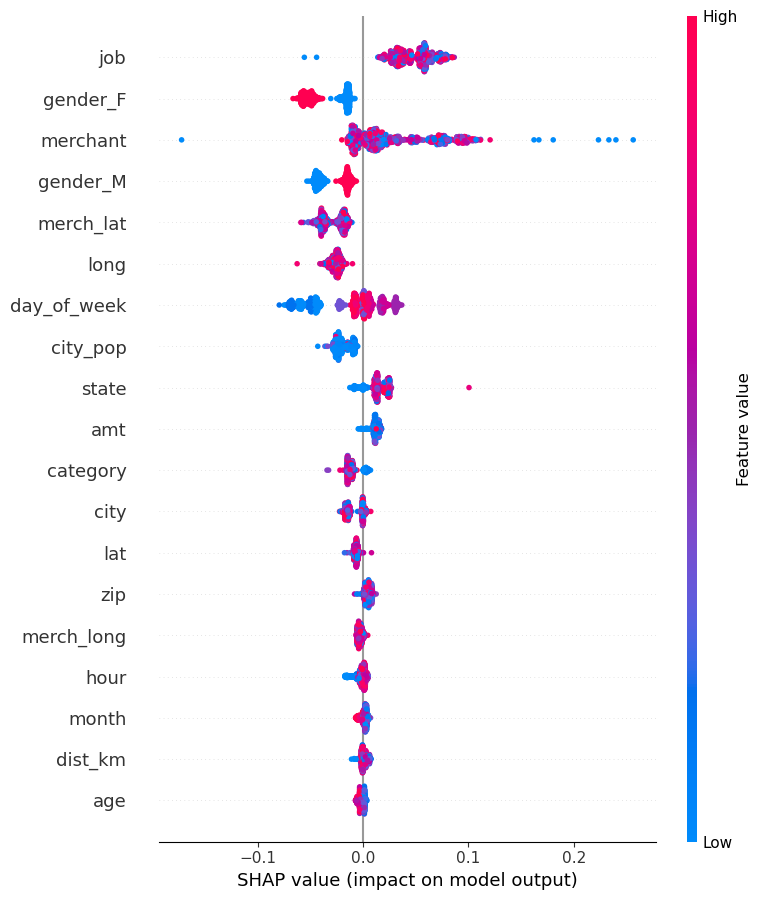

In [44]:
import shap
import matplotlib.pyplot as plt

# Get classifier and SHAP values
clf = rf_search.best_estimator_.named_steps['clf']
explainer = shap.TreeExplainer(clf)

X_sample = X_train.sample(n=min(1000, len(X_train)), random_state=42)
shap_values = explainer.shap_values(X_sample)

# Fix: Select class 1 from the 3D array
shap_values_class1 = shap_values[:, :, 1]

# Summary plot with all features
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_class1, X_sample, max_display=20, show=False)
plt.tight_layout()
plt.savefig("shap_summary_all_features.png", dpi=300, bbox_inches='tight')
plt.show()